In [ ]:
!pip install -U torch torchvision diffusers transformers accelerate bitsandbytes

In [ ]:
!pip install -U peft diffusers

In [ ]:
import os
import glob
import gc
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
import bitsandbytes as bnb

In [4]:
DATA_DIR = '/kaggle/input/outpainting/data_1' 
OUTPUT_DIR = '/kaggle/working/sd-inpaint-license-plate'
MODEL_NAME = "runwayml/stable-diffusion-inpainting"

RESOLUTION = 512
BATCH_SIZE = 4        
NUM_EPOCHS = 10
LEARNING_RATE = 1e-5

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [6]:
def prepare_latents():
    
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    dtype = torch.float16
    
    tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder").to(device, dtype=dtype)
    vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae").to(device, dtype=dtype)
    
    images = sorted(glob.glob(os.path.join(DATA_DIR, 'images', '*.*')))
    masks = sorted(glob.glob(os.path.join(DATA_DIR, 'masks', '*.*')))
    
    if len(images) == 0: raise ValueError("Can not find image")

    img_transform = transforms.Compose([
        transforms.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((RESOLUTION, RESOLUTION), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.ToTensor()
    ])
    
    cached_data = []
    
    prompt = "a photo of a car"
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        prompt_embeds = text_encoder(text_input.input_ids.to(device))[0].cpu()
    
    for i in tqdm(range(len(images))):
        try:
            img = Image.open(images[i]).convert("RGB")
            mask_plate = Image.open(masks[i]).convert("L") 
            
            mask_plate = mask_plate.resize((RESOLUTION, RESOLUTION), Image.NEAREST)
            inpainting_mask_np = 255 - np.array(mask_plate)
            inpainting_mask = Image.fromarray(inpainting_mask_np)
            
            img_np = np.array(img.resize((RESOLUTION, RESOLUTION)))
            img_np[inpainting_mask_np > 127] = 127 # Tô xám vùng vẽ
            masked_img = Image.fromarray(img_np)
            
            pixel_values = img_transform(img).unsqueeze(0).to(device, dtype=dtype)
            masked_image_tensor = img_transform(masked_img).unsqueeze(0).to(device, dtype=dtype)
            mask_tensor = mask_transform(inpainting_mask).unsqueeze(0).to(device, dtype=dtype)
            
            with torch.no_grad():
                latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215
                masked_latents = vae.encode(masked_image_tensor).latent_dist.sample() * 0.18215
                mask_64 = torch.nn.functional.interpolate(mask_tensor, size=(64, 64))
            
            cached_data.append({
                "latents": latents.cpu(),
                "masked_latents": masked_latents.cpu(),
                "mask": mask_64.cpu(),
                "prompt_embeds": prompt_embeds
            })
        except Exception as e:
            continue

    del vae, text_encoder, tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    print(f"Processed {len(cached_data)}")
    return cached_data

In [7]:
class LatentDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

In [8]:
def collate_fn(examples):
    latents = torch.cat([x["latents"] for x in examples])
    masked_latents = torch.cat([x["masked_latents"] for x in examples])
    mask = torch.cat([x["mask"] for x in examples])
    prompt_embeds = torch.cat([x["prompt_embeds"] for x in examples])
    return latents, masked_latents, mask, prompt_embeds

In [9]:
def visualize_batch(dataloader, model_name, device="cuda"):
    
    try:
        vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device, dtype=torch.float16)
    except:
        vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device)

    latents, masked_latents, mask, _ = next(iter(dataloader))
    
    latents = latents.to(device, dtype=torch.float16)
    masked_latents = masked_latents.to(device, dtype=torch.float16)
    
    with torch.no_grad():
        # 3. Decode
        recon_gt = vae.decode(latents / 0.18215).sample
        recon_masked = vae.decode(masked_latents / 0.18215).sample
    
    recon_gt = (recon_gt / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).float().numpy()
    recon_masked = (recon_masked / 2 + 0.5).clamp(0, 1).cpu().permute(0, 2, 3, 1).float().numpy()
    
    mask_vis = mask.cpu().permute(0, 2, 3, 1).float().numpy()
    
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(min(2, len(latents))):
        axs[i, 0].imshow(recon_gt[i])
        axs[i, 0].set_title("Target (Original)")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(recon_masked[i])
        axs[i, 1].set_title("Input (Masked)")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(mask_vis[i].squeeze(), cmap='gray')
        axs[i, 2].set_title("Mask")
        axs[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    del vae
    torch.cuda.empty_cache()

# Training

In [10]:
def main():
    # Prepare Data
    data = prepare_latents()
    dataset = LatentDataset(data)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    
    # Setup Accelerator
    accelerator = Accelerator(mixed_precision="fp16")
    
    if accelerator.is_main_process:
        visualize_batch(dataloader, MODEL_NAME, accelerator.device)

    # Load UNet
    unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
    noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
    
    unet.enable_gradient_checkpointing()
    
    # Optimizer
    optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=LEARNING_RATE)
    
    unet, optimizer, dataloader = accelerator.prepare(unet, optimizer, dataloader)
    
    
    for epoch in range(NUM_EPOCHS):
        unet.train()
        total_loss = 0
        
        for latents, masked_latents, mask, encoder_hidden_states in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=accelerator.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # Input
            unet_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)
            
            # Predict
            noise_pred = unet(unet_input, timesteps, encoder_hidden_states).sample
            
            # Loss 
            loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")
            
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1} - Loss: {total_loss/len(dataloader):.5f}")
        
        if (epoch + 1) % 5 == 0:
            out_path = os.path.join(OUTPUT_DIR, f"checkpoint-ep{epoch+1}")
            unet_to_save = accelerator.unwrap_model(unet)
            unet_to_save.save_pretrained(out_path)
            print(f"Saved model at: {out_path}")

    print("Done")

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/1350 [00:00<?, ?it/s]

Processed 1350


An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


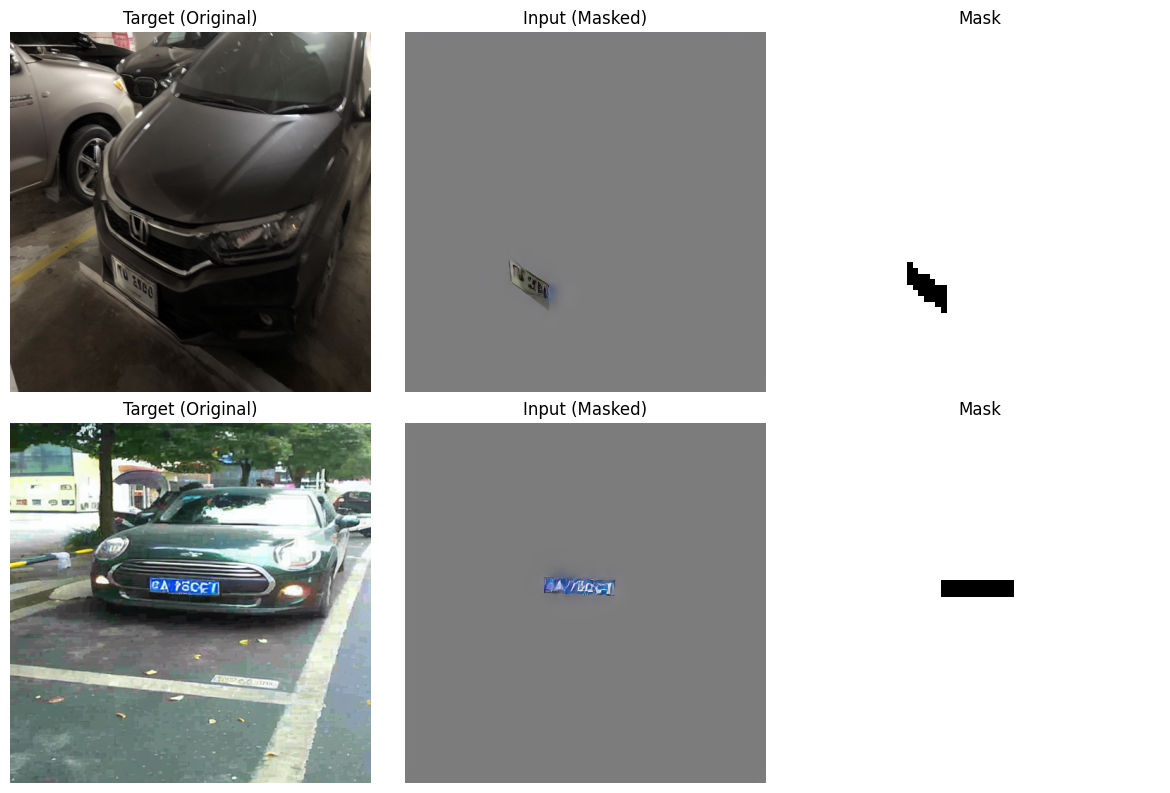

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Epoch 1:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.14936


Epoch 2:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.14867


Epoch 3:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.15802


Epoch 4:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.14698


Epoch 5:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.14863
Saved model at: /kaggle/working/sd-inpaint-license-plate/checkpoint-ep5


Epoch 6:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.14795


Epoch 7:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.13960


Epoch 8:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 8 - Loss: 0.15414


Epoch 9:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 9 - Loss: 0.14433


Epoch 10:   0%|          | 0/338 [00:00<?, ?it/s]

Epoch 10 - Loss: 0.14877
Saved model at: /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10
Done


In [11]:
if __name__ == "__main__":
    main()

# Inference

In [24]:
import torch
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel
from PIL import Image
import numpy as np

In [25]:
def inference_plate(
    crop_path, 
    model_path, 
    rotate=0,       
    translate_x=0, 
    translate_y=0,  
    output_path="result.png"
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=torch.float16,
        safety_checker=None
    ).to(device)
    
    print(f"Loading Fine-tuned UNet from {model_path}...")
    try:
        unet = UNet2DConditionModel.from_pretrained(
            model_path, 
            torch_dtype=torch.float16
        ).to(device)
        pipe.unet = unet
    except Exception as e:
        print(f"Error load UNet: {e}")
        return

    IMG_SIZE = 512
    
    crop_img = Image.open(crop_path).convert("RGBA")
    
    w, h = crop_img.size
    target_w = int(IMG_SIZE * 0.25) 
    scale = target_w / w
    target_h = int(h * scale)
    crop_resized = crop_img.resize((target_w, target_h), Image.BICUBIC)
    
    # Rotate
    crop_rotated = crop_resized.rotate(rotate, expand=True, resample=Image.BICUBIC, fillcolor=(0,0,0,0))
    
    new_w, new_h = crop_rotated.size
    
    # Translate
    center_x = (IMG_SIZE - new_w) // 2
    center_y = int(IMG_SIZE * 0.65)
    
    pos_x = center_x + translate_x
    pos_y = center_y + translate_y
    
    # Create input image
    image = Image.new("RGB", (IMG_SIZE, IMG_SIZE), (127, 127, 127))
    
    image.paste(crop_rotated, (pos_x, pos_y), mask=crop_rotated)
    
    # Create mask
    mask = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)

    plate_alpha = crop_rotated.split()[-1] 
    
    plate_shape_black = Image.new("L", (new_w, new_h), 0)
    
    mask.paste(plate_shape_black, (pos_x, pos_y), mask=plate_alpha)
    
    prompt = "a photo of a car"
    negative_prompt = "low quality, blurry, distorted, text, watermark, bad anatomy, cropped"
    
    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        num_inference_steps=30,
        guidance_scale=7.5,
        strength=1.0
    ).images[0]
    
    result.paste(crop_rotated, (pos_x, pos_y), mask=crop_rotated)
    
    result.save(output_path)
    
    try:
        from IPython.display import display
        print(f"Rotation angle: {rotate}°, Move X: {translate_x}, Move Y: {translate_y}")
        display(result)
    except:
        result.show()

In [26]:
img_1 = "/kaggle/input/outpainting/data_1/inference/crop_margin/image_00000.png"
img_2 = "/kaggle/input/outpainting/data_1/inference/crop_margin/image_00001.png"

In [27]:
ckpt_path = "/kaggle/working/sd-inpaint-license-plate/checkpoint-ep10"

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: 0, Move Y: 0


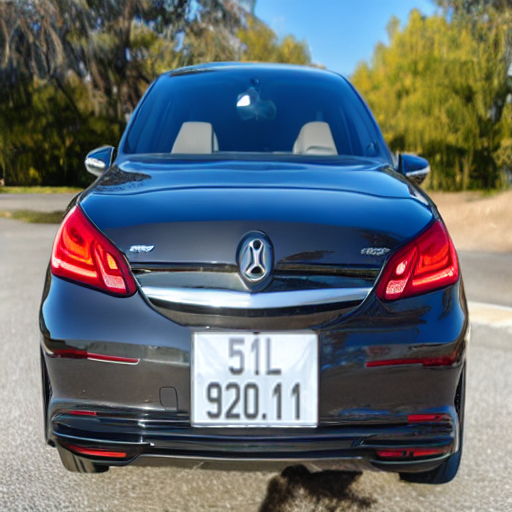

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: 0, Move Y: 0


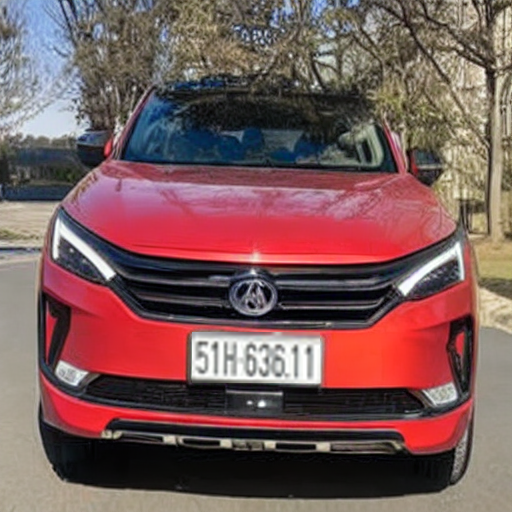

In [28]:
inference_plate(img_1, ckpt_path)
inference_plate(img_2, ckpt_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 10°, Move X: 0, Move Y: 0


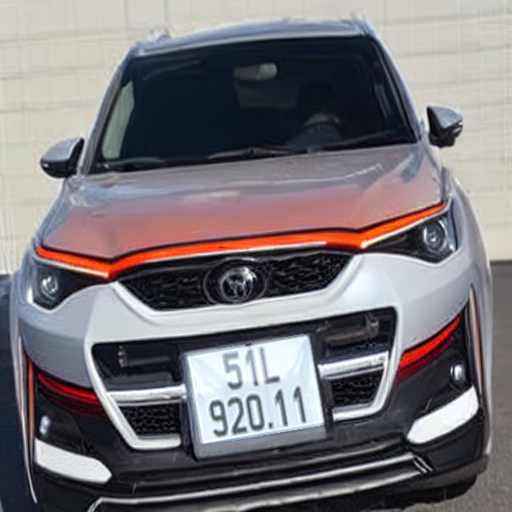

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 20°, Move X: 0, Move Y: 0


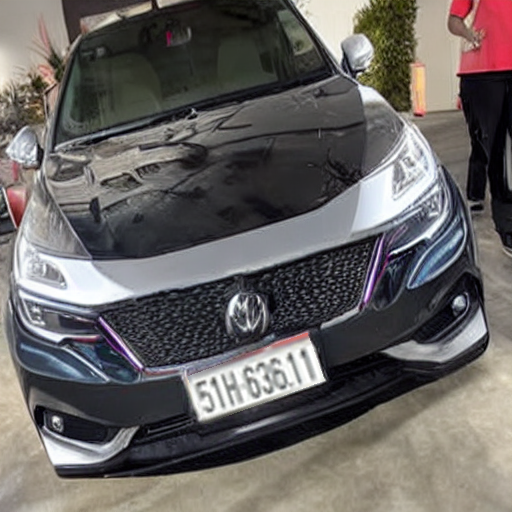

In [29]:
inference_plate(img_1, ckpt_path, rotate=10)
inference_plate(img_2, ckpt_path, rotate=20)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: -15°, Move X: 0, Move Y: 0


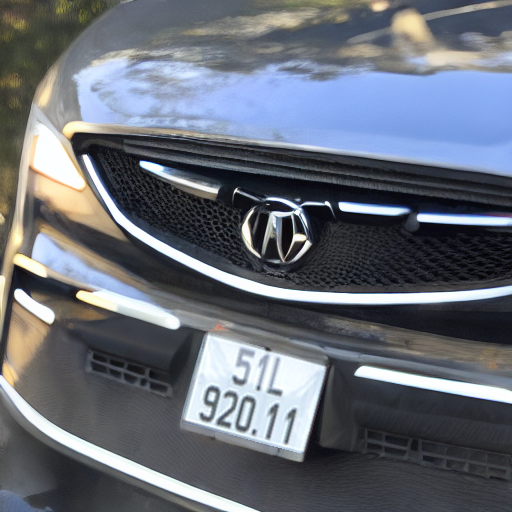

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: -10°, Move X: 0, Move Y: 0


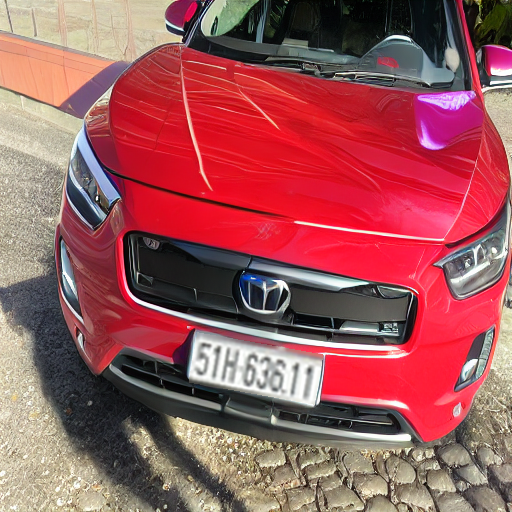

In [30]:
inference_plate(img_1, ckpt_path, rotate=-15)
inference_plate(img_2, ckpt_path, rotate=-10)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: -40, Move Y: 0


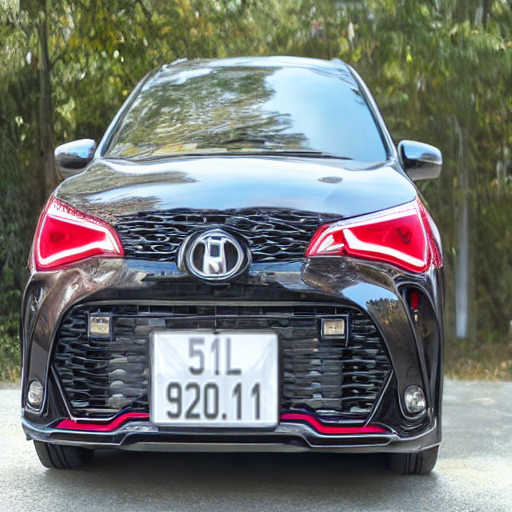

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: -20, Move Y: 0


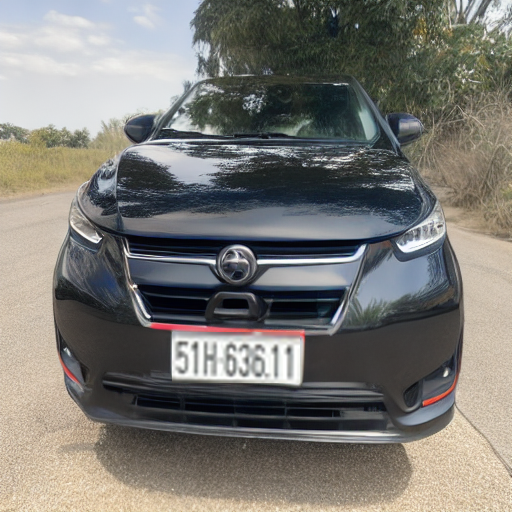

In [31]:
inference_plate(img_1, ckpt_path, translate_x=-40)
inference_plate(img_2, ckpt_path, translate_x=-20)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: 15, Move Y: 0


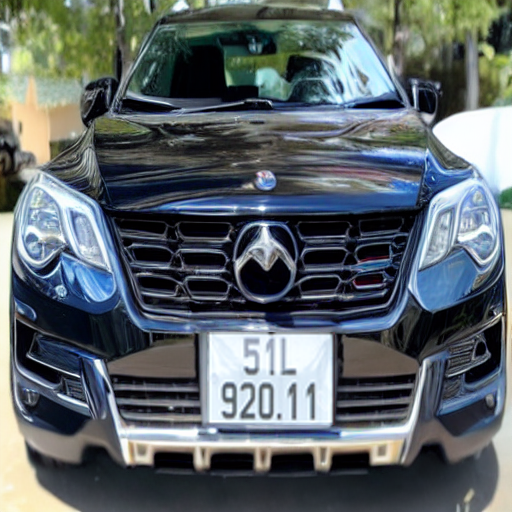

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 0°, Move X: 30, Move Y: 0


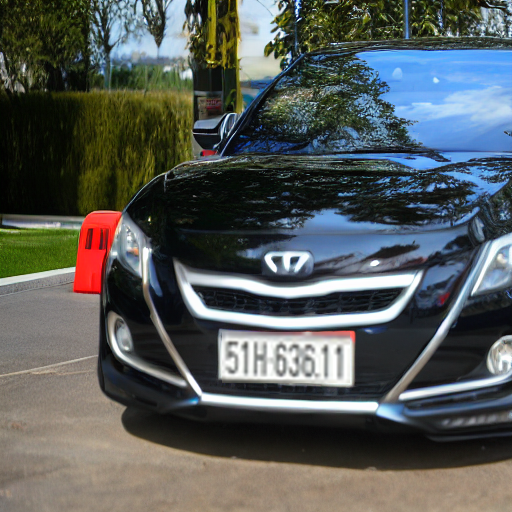

In [32]:
inference_plate(img_1, ckpt_path, translate_x=15)
inference_plate(img_2, ckpt_path, translate_x=30)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 10°, Move X: 30, Move Y: -20


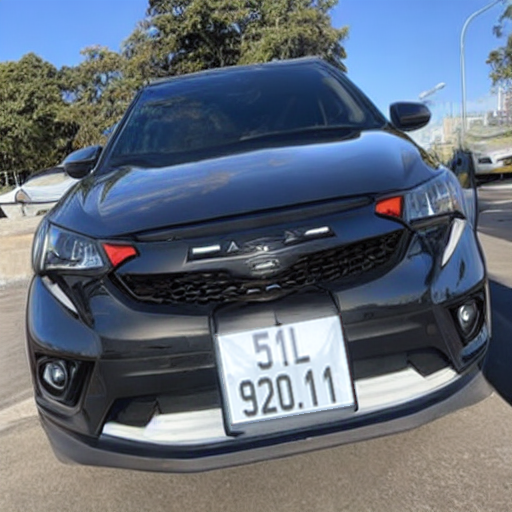

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelin

Loading Fine-tuned UNet from /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10...


  0%|          | 0/30 [00:00<?, ?it/s]

Rotation angle: 15°, Move X: 40, Move Y: -10


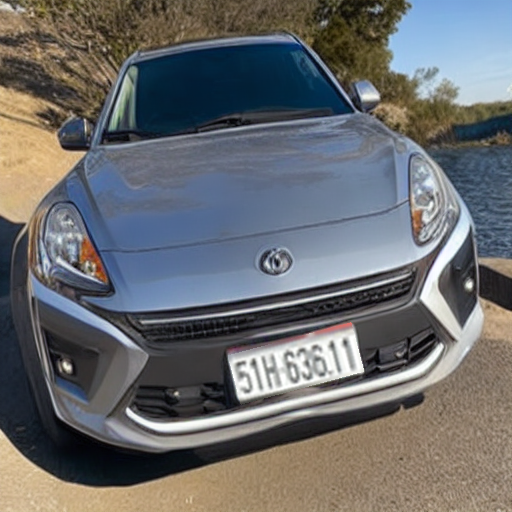

In [33]:
inference_plate(img_1, ckpt_path, rotate=10, translate_x=30, translate_y=-20)
inference_plate(img_2, ckpt_path, rotate=15, translate_x=40, translate_y=-10)

In [35]:
!zip -r /kaggle/working/model_ep10.zip /kaggle/working/sd-inpaint-license-plate/checkpoint-ep10
from IPython.display import FileLink
FileLink('/kaggle/working/model_ep10.zip')

  adding: kaggle/working/sd-inpaint-license-plate/checkpoint-ep10/ (stored 0%)
  adding: kaggle/working/sd-inpaint-license-plate/checkpoint-ep10/config.json (deflated 65%)
  adding: kaggle/working/sd-inpaint-license-plate/checkpoint-ep10/diffusion_pytorch_model.safetensors (deflated 7%)


/kaggle/working/model_ep10.zip